In [3]:
from sympy import init_printing, Symbol,lambdify, symbols, Matrix
init_printing()
import OneLoopLFVHD as lfvhd
from OneLoopLFVHD.LFVHDFeynG_mpmathDelta import Delta, delta

In [4]:
from seesaw_FF import TrianglesOneFermion, TrianglesTwoFermion, Bubbles,DiagramsOneFermionW, DiagramsOneFermionG
from seesaw_FF import g, mW, Uv, Uvc, mn, m, C, Cc, a,b,i,h
from seesaw_FF import j as jj

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from mpmath import *

In [7]:
mp.dps = 150; mp.pretty = True

In [8]:
import numpy as np

In [9]:
#import subprocess as s

In [10]:
from multiprocessing import Pool
#from time import time

In [11]:
def speedup_array(f,array,procs=4): 
    pool = Pool(procs,maxtasksperchild=100).map(f, array)
    result = np.array(list(pool))
    return result

## Neutrino oscillation and lepton data

Neutrino benchmark is given by 

In [12]:
from OneLoopLFVHD.neutrinos import NuOscObservables
Nudata = NuOscObservables

In [13]:
m1 = mpf('1e-12')  #GeV 

#current values to Square mass differences
d21 = mpf(str(Nudata.squareDm21.central))*mpf('1e-18')# factor to convert eV^2 to GeV^2
d31 = mpf(str(Nudata.squareDm31.central))*mpf('1e-18')

#d21 = 7.5e-5*1e-18
#d31 = 2.457e-3*1e-18
m2 = sqrt(m1**2 + d21)
m3 = sqrt(m1**2 + d31)

m4 = lambda m6: m6/3
m5 = lambda m6: m6/2

We calls from [Unu_seesaw.py](Unu_seesaw.py) the `diagonalizationMnu` function previously created to perform numerically the diagonalization of $6 \times 6$ mass matrix. Here we choose which scenary for heavy neutrino we consider.

In [14]:
from Unu_seesaw_Tome import diagonalizationMnu_svd as diagonalizationMnu
diagonalizationMnu1 = lambda m1, M, mu: diagonalizationMnu(
    m1,m2,m3,M,mu)
#Mnu1 = lambda m1,m6: Mnu(m1,m2,m3,m6/mpf('3.0'),m6/mpf('2.0'),m6)

#diagonalizationMnu1 = lambda m1,m6: diagonalizationMnu(
#    m1,m2,m3,m6,m6,m6)

In [15]:
mnk, UL,UR = diagonalizationMnu1(m1,1e15,mpf('1e3'))#0.003908
mp.nprint(mp.chop(mnk))

[1.0e+15]
[1.0e+15]
[    0.0]
[    0.0]
[    0.0]


We introduce the values to $g$, $m_W$, $m_h$ and leptons masses, which will be susbtitute in the simbolic expressions.

In [16]:
from OneLoopLFVHD.data import ml

In [17]:
mh,ma,mb = symbols('m_h,m_a,m_b',real=True)

v = mpf('174')
valores ={mW:mpf('80.379'),mh:mpf('125.10'),g:(2*mpf('80.379'))/v}

cambios_hab = lambda a,b:{lfvhd.ma:valores[mh],lfvhd.mi:ml[a],lfvhd.mj:ml[b]}

## Diagrams with one fermion in the loop.

In the case of diagram with only one neutrino in the loop which are labeled by the index $i$. the diagrams are 8 which are stored in `TrianglesOneFermion` and `Bubbles` lists.To other side, we need to consider a summatory of 6 neutrino generation and the GIM mechanism. First we do a auxiliar simbolic substitutions related to the following code.

In [18]:
Ubi, Ucai,mni = symbols('U_{bi}, {{U_{ai}^*}},m_{n_i}')
UnuOne = {mn[i]:mni,Uv[b,i]:Ubi,Uvc[a,i]:Ucai}

A simple implementation to the GIM mechanism to any simbolic form factor

In [19]:
def GIM_One(exp, fermion_mass):
    '''
    Function to apply the GIM mechanism in the form factors from diagrams with one neutrino in the loop 
    (This function is adapted only to this model seesaw and this notebook). 
    
    input
    ---------
        exp: must be a form factor taken from a diagram of OneLoopLFVHD.
    
    Return
    ---------
        OneLoopLFVHD expresion (sympy expression): The output is the resultant form factor simplified by
        the GIM mechanism, Only return the term which contains mni. 
    '''
    from sympy import Add
    args = exp.expand().args
    func = exp.expand().func
    if isinstance(func,Add):
        exp_GIM = Add(*[t for t in args if t.has(fermion_mass)]).simplify()
    else:
        exp_GIM = exp
    return exp_GIM

When we create our numeric functions from symblic form factors we will sum over the neutrino generations by the function `sumOne`

In [20]:
def sumOne(M,mu,Aab,a,b): 
    '''
    Function which sums over neutrino generation conidering the structure of Upmns matrix before calculated.
    
    Input
    --------
        m6 (float): the haviet mass
        Aab: funtion asociated to form factor
        a,b (int): indexes of leptons a,b=1,2 or 3
        
    Output
    --------
        out (float): numeric summation of the form factor over the 6 neutrino generations.
    '''
    mnk,UnuL,UnuR = diagonalizationMnu1(m1,M,mu)
    Unu = UnuR
    Unu_dagger = UnuL
    FF = []
    for k in range(1,6):
        if mnk[k-1] > mpf('1e-24'):
            # A = Aab(mnk[k-1],Unu[b-1,k-1],conj(Unu[a-1,k-1]))
            A = Aab(mnk[k-1],Unu[b-1,k-1],Unu_dagger[k-1,a-1])
            # print('Ai = ',A)
            FF.append(A)
    out = mp.fsum(FF)
    return out


Now, we build a main function to convert the symbolic form factor to numeric functions. This function is given below

In [21]:
from OneLoopLFVHD.data import replaceBs, pave_functions# Auxiliary functions

In [22]:
# bubbleniG = Bubbles[1]
# bubbleGni = Bubbles[3]
# bubbleniW = Bubbles[0]
# bubbleWni = Bubbles[2]
def numeric_sum_diagramsOne(a,b,quirality='L'):
    '''
    This function create a function which only depends on m6 and represent the sum of all form factors
    associated to diagrams with one fermion in the loop and also considering the 6 neutrino generations.
    
    Input
    ---------
        a,b (int): indexes of leptons, a,b = 1,2 or 3
        quirality (string): represents the chirality of the diagrams, it can be L or R:
        
    Output:
        sum_over_index_i (function): returns the function which represent the sum of all diagrams and 
        over the neutrino index i. This function only depends on m6.
    '''
    #[TrianglesOneFermion[0],TrianglesOneFermion[1],TrianglesOneFermion[2]],
    #[bubbleniG,bubbleGni]
    FFOneFer_list = []
    for Set in [TrianglesOneFermion,Bubbles]:#TrianglesOneFermion,Bubbles
        for dia in Set:
            if quirality=='L':
                x = dia.AL().subs(lfvhd.D,4).subs(lfvhd.B12_0(mW,mW),0).subs(cambios_hab(a,b)).subs(valores).subs(UnuOne)
            elif quirality=='R':
                x = dia.AR().subs(lfvhd.D,4).subs(lfvhd.B12_0(mW,mW),0).subs(cambios_hab(a,b)).subs(valores).subs(UnuOne)
            else:
                raise ValueError('quirality must be L or R')
            f = lambdify([mni,Ubi,Ucai],# depends on three parameters
                         replaceBs(x), # replace B function by auxiliary functions which do not has problembs in lambdify
                         modules=[pave_functions(valores[mh],a,b,lib='mpmathDelta'),'mpmath']
                        ) #numeric Form factor
            #print(f(1,2,3))
            #fsum = lambda m6:sumOne(m6,f,a,b)
            FFOneFer_list.append(f)
    def sum_over_index_i(M,mu):
        out = []
        xs = []
        for FFab in FFOneFer_list:
            FF_sum_over_i = sumOne(M,mu,FFab,a,b) # sum over neutrino generations
            out.append(FF_sum_over_i)
            xs.append(FF_sum_over_i)
        return np.array(xs), mp.fsum(out)
    return sum_over_index_i

In [23]:
nprint(chop(numeric_sum_diagramsOne(3,1,quirality='R')(1,2)[1]))

-7.99632e-21


In [24]:
mu0 = mpf('1e3')
def ALOneTot23(M, mu=mu0):
    return numeric_sum_diagramsOne(2,3,quirality='L')(M,mu)[0]
def AROneTot23(M, mu=mu0):
    return numeric_sum_diagramsOne(2,3,quirality='R')(M,mu)[0]

def ALOneTot13(M, mu=mu0):
    return numeric_sum_diagramsOne(1,3,quirality='L')(M,mu)[0]
def AROneTot13(M, mu=mu0):
    return numeric_sum_diagramsOne(1,3,quirality='R')(M,mu)[0]


def ALOneTot12(M, mu=mu0):
    return numeric_sum_diagramsOne(1,2,quirality='L')(M,mu)[0]
def AROneTot12(M, mu=mu0):
    return numeric_sum_diagramsOne(1,2,quirality='R')(M,mu)[0]


Now to plot we choose the interval $m_{n_6} \in [10^{-1},10^{15}]$

In [25]:
n = 50
expmp = linspace(1,4,n)
m6np = np.array([mpf('10.0')**k for k in expmp])#np.logspace(-1,15,n)

Now, we evaluate our form factor numeric function in the chose interval. To do a faster evaluation we use `speedup_array` function

In [26]:
%%time
YLOne23 = speedup_array(ALOneTot23,m6np)
YROne23 = speedup_array(AROneTot23,m6np)

YLOne13 = speedup_array(ALOneTot13,m6np)
YROne13 = speedup_array(AROneTot13,m6np)

YLOne12 = speedup_array(ALOneTot12,m6np)
YROne12 = speedup_array(AROneTot12,m6np)


CPU times: user 568 ms, sys: 273 ms, total: 841 ms
Wall time: 4min 12s


In [27]:
diagramas_one = {
    0:'niWW',1:'niWG',2:'niGW',3:'niGG',
    4:'niW',5:'niG',6:'Wni',7:'Gni'}

Finalli we can plot the behavior of the sum of form factor for diagrams with one fermion.

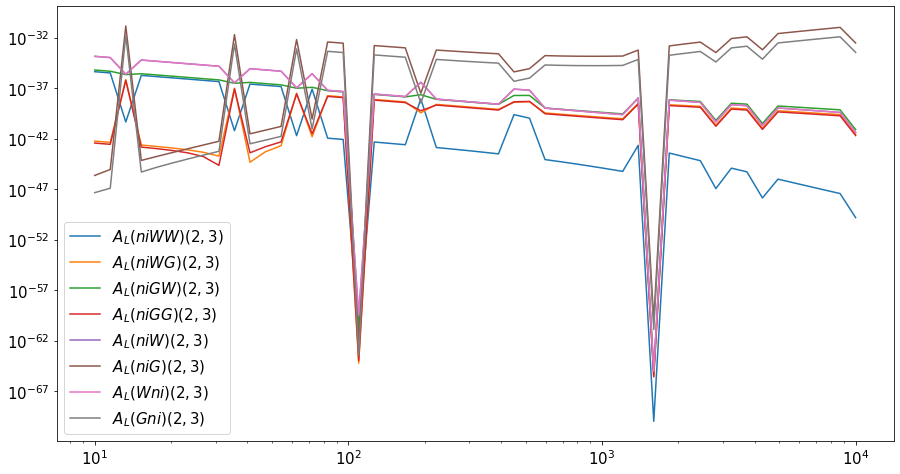

In [29]:
plt.figure(figsize=(15,8))
for dia in diagramas_one:
    plt.loglog(np.real(m6np),abs(YLOne23[:,dia])**2,'-',
    label=f'$A_L({diagramas_one[dia]})(2,3)$')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)

## Form factor with two fermion in the loop.

In this case we only have 2 diagrams stored in `TrianglesTwoFermion` list. In this case we have two neutrino indexes $i$ and $j$.Then, we have a doble summatory in this case.  First we do an auxiliar simbolic substitutions related to the following code

In [30]:
mnj = symbols('m_{n_j}',positive=True)
Cijs, Cijcs, Ubj = symbols('C_{ij}, {{C_{ij}^*}},U_{bj}')
UnuTwo = {mn[i]:mni,mn[jj]:mnj,C[i,jj]:Cijs, Cc[i,jj]:Cijcs, Uv[b,jj]:Ubj, Uvc[a,i]:Ucai}
UnuTwo

In [31]:
fsL = lambda k,a,b:TrianglesTwoFermion[k].AL().subs(lfvhd.D,4).subs(cambios_hab(a,b)).subs(valores).subs(UnuTwo)
fsR = lambda k,a,b:TrianglesTwoFermion[k].AR().subs(lfvhd.D,4).subs(cambios_hab(a,b)).subs(valores).subs(UnuTwo)

In [32]:
fL = lambda k,a,b:lambdify([mni,mnj,Ubj,Ucai,Cijs,Cijcs],replaceBs(fsL(k,a,b)),
                     modules=[pave_functions(valores[mh],a,b,lib='mpmathDelta'),'mpmath'] )
fR = lambda k,a,b:lambdify([mni,mnj,Ubj,Ucai,Cijs,Cijcs],replaceBs(fsR(k,a,b)),
                     modules=[pave_functions(valores[mh],a,b,lib='mpmathDelta'),'mpmath'] )

In [33]:
fL(0,2,3)(1,2,3,4,5,6)

(-0.000000770002587592875178297254370771239143243580169229367583326257371082482462521202271940822188311677991348004627406290783961356426131547830848108844133991 + 0.000000462092519188019980639018875718193596730334899107338999454714371346492507741300999645185279533568451530432634726451045072314290856752981097503810917502j)

In [34]:
fL(1,2,3)(1,2,3,4,5,6)

(0.0000000612161778033573405870797961189152753352949576163605958389615275937832293749646333904565815973394057466498399557594300266051215187849381881534798952559 - 0.000000895410710908271482476653077144275515199602413352368993446775372004008469345103042039276144794778023402004833519479413940517000367481800582059178307699j)

Now, we do a function to do the doble summatory on the neutrino generetions

In [36]:
import pdb

In [38]:
def sumatwo(M, mu,k,a,b,quirality='L'):
    xs = []
    if quirality=='L':
        g = fL(k,a,b)
    elif quirality=='R':
        g = fR(k,a,b)
    else:
        raise ValueError('quirality must be L or R')
        
    mnk,UnuL,UnuR = diagonalizationMnu1(m1,M, mu)
    Unu = UnuR
    Unu_dagger = UnuL
    #Cij = lambda i,j: mp.fsum([Unu[c,i]*conj(Unu[c,j]) for c in range(3)])
    Cij = lambda i,j: mp.fsum([Unu[c,i]*Unu_dagger[j,c] for c in range(3)])
    for p in range(1,6):
        for q in range(1,6):
            if mnk[p-1] >1e-12 or mnk[q-1] > 1e-12:
                #if (p in [1,2,3] and q in [4,5,6]) or (p in [4,5,6] and q in [1,2,3]):
                x = g(mnk[p-1],mnk[q-1],Unu[b-1,q-1],Unu_dagger[p-1,a-1],
                Cij(p-1,q-1),conj(Cij(p-1,q-1)))
                xs.append(x)
    return mp.fsum(xs)
pdb.set_trace()
sumatwo(1e4, mu0, 0, 2, 3, 'L')

--Return--
None
> /tmp/ipykernel_87763/3651621272.py(23)<module>()
     20                 Cij(p-1,q-1),conj(Cij(p-1,q-1)))
     21                 xs.append(x)
     22     return mp.fsum(xs)
---> 23 pdb.set_trace()
     24 sumatwo(1e4, mu0, 0, 2, 3, 'L')



Then the total contribution of the diagrams with two fermions in the loop is given by

In [58]:
def totaltwo(M,mu,a,b,quirality='L'):
    return np.array([sumatwo(M, mu,0,a,b,quirality),sumatwo(M, mu, 1, a, b, quirality)])

In [59]:
def ALTwoTot23(M, mu=mu0):
    return totaltwo(M, mu,2,3,'L')
def ARTwoTot23(M, mu=mu0):
    return totaltwo(M, mu,2,3,'R')


def ALTwoTot13(M, mu=mu0):
    return totaltwo(M, mu,1,3,'L')
def ARTwoTot13(M, mu=mu0):
    return totaltwo(M, mu,1,3,'R')


def ALTwoTot12(M, mu=mu0):
    return totaltwo(M, mu,1,2,'L')
def ARTwoTot12(M, mu=mu0):
    return totaltwo(M, mu,1,2,'R')


In [64]:
abs(ALTwoTot23(2,mu0))

ZeroDivisionError: 

In [62]:
%%time
YLTwo23 = speedup_array(ALTwoTot23,m6np)
YRTwo23 = speedup_array(ARTwoTot23,m6np)

YLTwo13 = speedup_array(ALTwoTot13,m6np)
YRTwo13 = speedup_array(ARTwoTot13,m6np)

YLTwo12 = speedup_array(ALTwoTot12,m6np)
YRTwo12 = speedup_array(ARTwoTot12,m6np)

ZeroDivisionError: 

In [ ]:
diagramas_two = {0:'Gninj',1:'Wninj'}

## Total Form Factors

In [ ]:
import pandas as pd

In [ ]:
def FF_frame(Yone,Ytwo):
    A_dict = {}
    A_dict['m6'] = m6np
    for dia_one in diagramas_one:
        A_dict[diagramas_one[dia_one]] = Yone[:,dia_one]
    for dia_two in diagramas_two:
        A_dict[diagramas_two[dia_two]] = Ytwo[:,dia_two]
    return pd.DataFrame(A_dict)

FF_frame23L = FF_frame(YLOne23,YLTwo23)
FF_frame23R = FF_frame(YROne23,YRTwo23)

FF_frame13L = FF_frame(YLOne13,YLTwo13)
FF_frame13R = FF_frame(YROne13,YRTwo13)

FF_frame12L = FF_frame(YLOne12,YLTwo12)
FF_frame12R = FF_frame(YROne12,YRTwo12)

In [ ]:
# def FF_frame(Ytwo):
#     A_dict = {}
#     A_dict['m6'] = m6np
#     for dia_two in diagramas_two:
#         A_dict[diagramas_two[dia_two]] = Ytwo[:,dia_two]
#     return pd.DataFrame(A_dict)

# FF_frame23L = FF_frame(YLTwo23)
# FF_frame23R = FF_frame(YRTwo23)

# FF_frame13L = FF_frame(YLTwo13)
# FF_frame13R = FF_frame(YRTwo13)

# FF_frame12L = FF_frame(YLTwo12)
# FF_frame12R = FF_frame(YRTwo12)

In [ ]:
#FF_frame23L

In [ ]:
FF_frame23L.to_csv('data_frames/FF_frame_23L_Tome.txt',sep='\t',index=None)
FF_frame23R.to_csv('data_frames/FF_frame_23R_Tome.txt',sep='\t',index=None)

FF_frame13L.to_csv('data_frames/FF_frame_13L_Tome.txt',sep='\t',index=None)
FF_frame13R.to_csv('data_frames/FF_frame_13R_Tome.txt',sep='\t',index=None)

FF_frame12L.to_csv('data_frames/FF_frame_12L_Tome.txt',sep='\t',index=None)
FF_frame12R.to_csv('data_frames/FF_frame_12R_Tome.txt',sep='\t',index=None)